In [ ]:
import os

from dotenv import load_dotenv


def load_environment_variables():
    """Load environment variables from a .env file."""
    load_dotenv()

    os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
    os.environ["COHERE_API_KEY"] = os.getenv("COHERE_API_KEY")
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./credentials.json"
    os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
    os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")


load_environment_variables()

from pprint import pprint
from typing import List

from agents.answer_grader import answer_grader
from agents.hallucination_grader import hallucination_grader
from agents.main_router import question_router
from agents.question_rewritter import question_rewriter
from agents.retrieval_grader import retrieval_grader
from langchain.schema import Document
from langgraph.graph import END, START, StateGraph
from rag.rag import (
    compress_documents,
    create_compressor,
    create_groq_llm,
    create_pathway_client,
    create_prompt_template,
    get_answer,
    retrieve_relevant_documents,
)
from tools.tools import web_search_tool
from typing_extensions import TypedDict
from agents.document_relevent_router import relevency_router
from agents.reasoning_agent import reasoner
from agents.finance_agent import finance_agent
from agents.query_decomposition import decomposer
from agents.answer_aggregator import aggregator

# print(os.environ["GOOGLE_APPLICATION_CREDENTIALS"])

llm = create_groq_llm()
prompt = create_prompt_template()


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    retriever = create_pathway_client()
    compressor = create_compressor()
    documents = retrieve_relevant_documents(retriever, question)
    compressed_docs = compress_documents(retriever, question, compressor)
    return {"documents": compressed_docs, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    print("Question: ", question)
    print("Documents: ", documents)

    # RAG generation
    # generation = rag_chain.invoke({"context": documents, "question": question})
    generation = get_answer(documents, question, llm, prompt)
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    filtered_documents = state["documents"]

    answerability = relevency_router.invoke(
        {"question": question, "context": filtered_documents}
    )
    if answerability != "answerable":
        print("---DECISION: REDIRECTING TO FINANCE AGENT ---")
        return "not_answerable"

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"


def finance_tool_agent(state):
    """
    Call finance agent tools.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---FINANCE AGENT---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    # generation = rag_chain.invoke({"context": documents, "question": question})
    generation = finance_agent.invoke(question)
    final_generation = []
    for item in generation:

        generation_output = item["name"] + " " + str(item["output"])
        final_generation.append(generation_output)
    print("Finance Agent", documents)
    return {
        "documents": documents,
        "question": question,
        "generation": ", ".join(final_generation),
    }


def reasoning_agent(state):
    """
    Reason based on the question and documents.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---REASON AGENT---")
    question = state["question"]
    documents = state["documents"]
    # print("Finance Reason Docs", documents)
    gen = state["generation"]

    generation = reasoner.invoke({"question": question, "documents": gen})
    # Create a document from the generation
    document = Document(page_content=generation)
    # Append the document to the list of documents
    documents.append(document)
    return {"documents": documents, "question": question}


def relevency_routing(state):
    """
    Route question to RAG or financial agent.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    documents = state["documents"]
    source = relevency_router.invoke({"question": question, "context": documents})
    if source.datasource == "answerable":
        print("---ROUTE QUESTION TO RAG---")
        return "answerable"
    elif source.datasource == "not_answerable":
        print("---ROUTE QUESTION TO FINANCIAL AGENT---")
        return "not_answerable"


def answerable_testing(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """
    print("--- RELEVANT TESTING---")
    question = state["question"]
    documents = state["documents"]
    ans = relevency_router.invoke({"question": question, "context": documents})
    if ans == "answerable":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        return "answerable"
    else:
        print(
            "---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, REDIRECTING TO FINANACE AGENT---"
        )
        return "not_answerable"
    # generation = state["generation"]

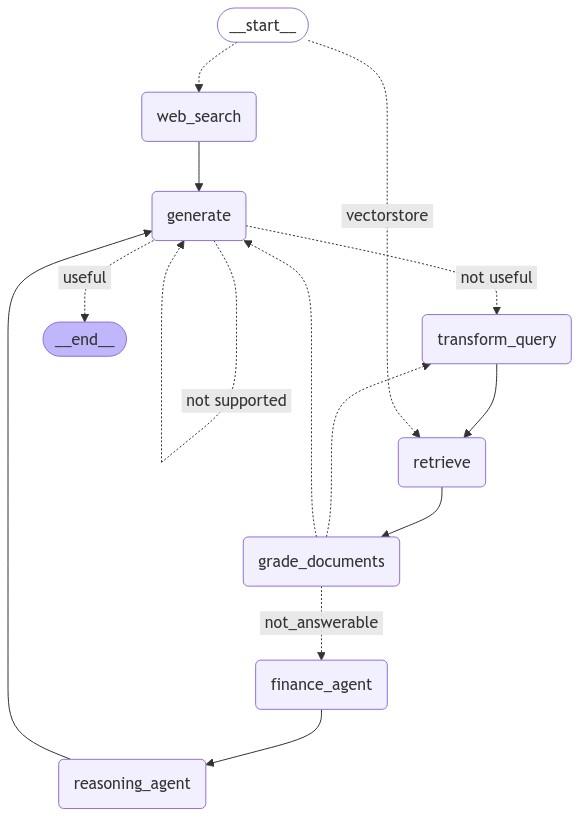

['What is the dividend policy of the company?', 'What are the key factors that determine the dividend policy of the company?', 'How does the company decide on the amount of dividend to pay to its shareholders?']

Processing query: What is the dividend policy of the company?
--------------------------------------------------
---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
Node 'web_search':

---

---GENERATE---
Question:  What is the dividend policy of the company?
Documents:  page_content='Dividend policy is the policy that the company adopts for paying out the dividends to the company's shareholders, which includes the percentage of the amount at which the dividend is to be paid out to the stockholders and how frequently the amount is paid to the company. Simply put, a dividend policy is a set of guidelines or rules that the
A dividend policy is a company's approach to distributing profits to its shareholders in the form of dividends. This policy outlines the 

AttributeError: 'tuple' object has no attribute 'metadata'

In [2]:
load_environment_variables()

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("finance_agent", finance_tool_agent)  # finance_agent
workflow.add_node("reasoning_agent", reasoning_agent)  # reasoning_agent

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "not_answerable": "finance_agent",
        "generate": "generate",
    },
)
# workflow.add_edge("grade_documents","relevency_router")
# workflow.add_conditional_edges(
#     "relevency_router",
#     relevant_testing,
#     {
#         "answerable": "generate",
#         "not_answerable": "finance_agent",
#     },
# )
workflow.add_edge("finance_agent", "reasoning_agent")
workflow.add_edge("reasoning_agent", "generate")
# workflow.add_edge("finance_agent", "reasoning_agent")
# workflow.add_edge("reasoning_agent", "generate")
# workflow.add_edge("relevant_testing", "generate")
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Run
inputs = {"question": "Dividend policy of the company"}
subQueries = decomposer.invoke(inputs).sub_queries
print(subQueries)
intermediate_results = []
results = []
# for subQuery in subQueries:
#     # print(subQuery)
#     intermediate_results.append(app.stream(subQuery))
#     # results.append(value["generation"])

# print(intermediate_results)
generations = []  # To store all generations

# Iterate through each sub-query
for sub_query in subQueries:
    print(f"\nProcessing query: {sub_query}")
    print("-" * 50)

    # Run the streaming process for this query
    for output in app.stream(
        {"question": sub_query}
    ):  # Assuming 'question' is the input key
        for key, value in output.items():
            print(f"Node '{key}':")
        print("\n---\n")

        # Store the final generation
        if "generation" in value:
            generations.append({"query": sub_query, "generation": value["generation"]})

# Print all collected generations
print("\nAll Generations:")
print("=" * 50)
for gen in generations:
    print(f"\nQuery: {gen['query']}")
    print("-" * 30)
    pprint(gen["generation"])

In [ ]:
answers = []
for gen in generations:
    print(f"\nQuery: {gen['query']}")
    print("-" * 30)
    answers.append(gen["generation"])
    pprint(gen["generation"])


Query: What is positional encoding?
------------------------------
''

Query: What is positional encoding?
------------------------------
('The answer to the question "What is positional encoding?" can be found in '
 'the provided context. \n'
 '\n'
 'Location: Attention is all you need_2pg.pdf, page: 2.\n'
 '\n'
 'Positional encoding is a technique used in deep learning models, '
 'particularly in transformer-based architectures, to preserve the order of '
 'input sequences. This is necessary because many deep learning models, such '
 'as recurrent neural networks (RNNs) and transformers, process input '
 'sequences in parallel, which can lead to a loss of positional information.\n'
 '\n'
 'In the context, it is mentioned that "we add \'positional encodings\' to the '
 'input embeddings at the bottoms of the encoder and decoder stacks. The '
 'positional encodings have the same dimension dmodel as the embeddings, so '
 'that the two can be summed."\n'
 '\n'
 'Additionally, the contex

In [ ]:
ans = aggregator.invoke({"question": inputs["question"], "answers": ", ".join(answers)})

In [ ]:
ans.sub_queries

'Positional encoding is a technique used in deep learning models, particularly in transformer-based architectures, to preserve the order of input sequences. This is necessary because many deep learning models, such as recurrent neural networks (RNNs) and transformers, process input sequences in parallel, which can lead to a loss of positional information. The concept of positional encoding in transformer models is a technique used to preserve sequential information in input data. Since transformer models rely heavily on self-attention mechanisms, which are permutation-invariant, they do not take into account the order of the input data. To address this issue, positional encoding is used to add positional information to the input data. According to the provided context, the positional encoding is added to the input embeddings at the bottoms of the encoder and decoder stacks. The positional encodings have the same dimension as the embeddings, so that the two can be summed. The context al

In [ ]:
import os
import streamlit as st
from pprint import pprint
import sys
import io
from dotenv import load_dotenv
from bs4 import BeautifulSoup
from langchain_community.callbacks import get_openai_callback
import matplotlib.pyplot as plt
import json
import os
import re
import logging
from pprint import pprint
from typing import List


def load_environment_variables():
    """Load environment variables from a .env file."""
    load_dotenv()
    os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
    os.environ["COHERE_API_KEY"] = os.getenv("COHERE_API_KEY")
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./credentials.json"
    os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
    os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")


load_environment_variables()

from agents.Chart_Agent import chart_generator
from agents.SQLAgent import SQLAgent
from agents.TableMaker import TableMaker
from agents.answer_aggregator import aggregator
from agents.answer_grader import answer_grader
from agents.document_relevent_router import relevency_router
from agents.finance_react_agent import finance_react_agent
from agents.finance_agent import finance_agent
from agents.hallucination_grader import hallucination_grader
from agents.main_router import question_router
from agents.query_decomposition import decomposer
from agents.question_rewritter import question_rewriter
from agents.reasoning_agent import reasoner
from agents.rectifier import rectifier
from agents.retrieval_grader import retrieval_grader
from agents.verification_agent import verifier
from langchain.schema import Document
from langgraph.graph import END, START, StateGraph
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from rag.rag import (
    compress_documents,
    create_compressor,
    create_groq_llm,
    create_openai_llm,
    create_pathway_client,
    create_prompt_template,
    get_answer,
    retrieve_relevant_documents,
)
from tools.bar_maker import generate_bar_chart
from tools.line_maker import generate_line_chart
from tools.pie_maker import generate_pie_chart
from tools.tools import web_search_tool
from typing_extensions import TypedDict

llm = create_openai_llm()
prompt = create_prompt_template()

question = "What are the revenue sources of alphabet inc"

# Initialize token tracking
# global tokens
# global inp_tok
tok = 0
pr_tok = 0

# Retrieval
retriever = create_pathway_client()
compressor = create_compressor()

tok, pr_tok, compressed_docs = compress_documents(retriever, question, compressor)
# tokens += tok
# inp_tok += pr_tok

if not compressed_docs:
    print("No documents retrieved or compressed.")

/DATA/anurag_2101ai04/miniconda3/envs/langchain/lib/python3.10/site-packages/langsmith/client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


OpenAI LLM initialized.


In [2]:
compressed_docs

[Document(metadata={'element_id': 'bf44605e69ac069340c1cd8384de2b61', 'filename': 'files', 'filetype': 'application/pdf', 'id': '1iZxH861lrPVI2Uk2yaovgDbHcm0xQrrk', 'languages': ['eng'], 'lastModifyingUser': {'displayName': 'Rishikant Chigrupaatii', 'emailAddress': 'rishikantchigrupaatii.24@gmail.com', 'kind': 'drive#user', 'me': False, 'permissionId': '17173739234292623764', 'photoLink': 'https://lh3.googleusercontent.com/a-/ALV-UjU1KD47uYx6j38l6-BffzjqvFLMonawkgCXyTROQl88HaI7QH2D=s64'}, 'mimeType': 'application/pdf', 'modifiedTime': '2024-10-28T17:50:01.000Z', 'name': 'rk.pdf', 'page_number': 31, 'parent_id': '7c574e3e94dcf6d069e731fc1789cf92', 'parents': ['1x3IhULE-PWgcDoZHrZbj4tYeEXXfYQ3j'], 'path': 'rk.pdf', 'seen_at': 1732973829, 'size': '38182', 'status': 'downloaded', 'thumbnailLink': 'https://lh3.googleusercontent.com/drive-storage/AJQWtBMyT68HusGnEIidzOkp4GV7M9__JtQHWMf9vaBYQi4fJ2U4rPQDZG38l6585f8doUTAt7tCGNBl1YkOu06vHkZOg1UdbrMIQ5D5FWNL_ALxu-rX=s220', 'trashed': False, 'type